In [1]:
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.image import ssim
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

Load MNIST dataset

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Generate dataset for outlier detection

In [3]:
# Treat digit “0” as the regular classt, import all images from class 0
regular = X_train[y_train==0]
# and digit “6” as the outlier class, and add 500 images of class 6
outlier = X_train[y_train==6][:500]
# Split your synthetic outlier dataset into 90% for training and 10% for testing.
regular_train, regular_test = train_test_split(regular, test_size=0.1)

In [4]:
regular_train = tf.cast(regular_train, tf.float32)/ 255
regular_test = tf.cast(regular_test, tf.float32)/ 255
outlier = tf.cast(outlier, tf.float32)/ 255

Both loss and ssim are worse for outlier class in both encoders

#  standard densely connected autoencoder

In [5]:
class Autoencoder(Model):
  def __init__(self, img_shape):
    super(Autoencoder, self).__init__()
    self.img_shape = img_shape   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(img_shape, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(784, activation='sigmoid'),
      tf.keras.layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(64)
autoencoder.compile(optimizer='adam', loss="mse")

In [6]:
autoencoder.fit(regular_train, regular_train,
                epochs=10,
                shuffle=True,
                validation_data=(regular_test, regular_test))

Epoch 1/10
167/167 [==============================] - 2s 8ms/step - loss: 0.0605 - val_loss: 0.0349
Epoch 2/10
167/167 [==============================] - 1s 8ms/step - loss: 0.0293 - val_loss: 0.0249
Epoch 3/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0221 - val_loss: 0.0202
Epoch 4/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0181 - val_loss: 0.0168
Epoch 5/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0153 - val_loss: 0.0145
Epoch 6/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0132 - val_loss: 0.0127
Epoch 7/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 8/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 9/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 10/10
167/167 [==============================] - 1s 7ms/step - loss: 0.0086 - val_loss: 0.0087

regular test data

In [7]:
encoded_imgs = autoencoder.encoder(regular_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [8]:
autoencoder.evaluate(regular_test, regular_test)

19/19 [==============================] - 0s 2ms/step - loss: 0.0087


0.008746592327952385

In [9]:
ssim(decoded_imgs, regular_test, max_val=1.0).numpy()

0.9166092

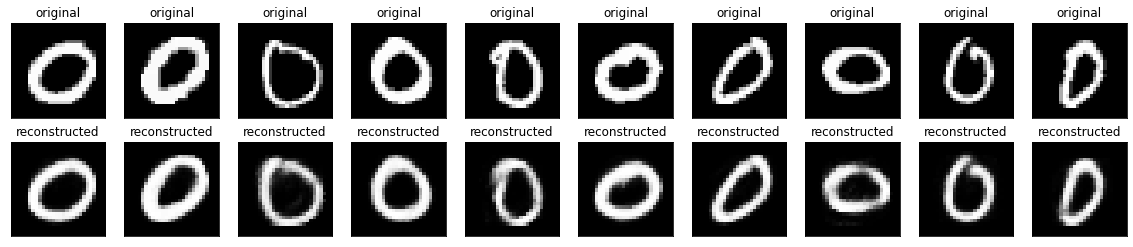

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(regular_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


outlier

In [11]:
encoded_imgs = autoencoder.encoder(outlier).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [12]:
autoencoder.evaluate(outlier, outlier)

16/16 [==============================] - 0s 2ms/step - loss: 0.0262


0.026215458288788795

In [13]:
ssim(decoded_imgs, outlier, max_val=1.0).numpy()

0.6511639

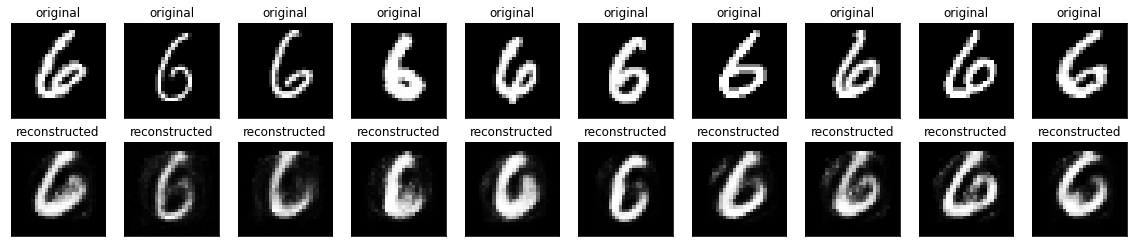

In [14]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(outlier[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


#   convolutional autoencode

In [15]:
# Reshape data
regular_train = tf.image.resize(np.expand_dims(regular_train, axis=3), (32, 32))
regular_test = tf.image.resize(np.expand_dims(regular_test, axis=3), (32, 32))
outlier = tf.image.resize(np.expand_dims(outlier, axis=3), (32, 32))

In [16]:
class AdversarialAE(Model):
  def __init__(self, img_shape, filters=[64,128]):
    super(AdversarialAE, self).__init__()
    self.img_shape = img_shape
    self.filters = filters

    self.encoder = self._build_encoder()
    self.decoder = self._build_decoder()

  def _build_encoder(self):

    inputs = x = tf.keras.layers.Input(shape=self.img_shape)
    for filter in self.filters:
      x = tf.keras.layers.Conv2D(filter, 3, strides=2,
                                 padding='same')(x)
      if not filter==self.filters[-1]:
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(0.2)(x)

    self.shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
    out = x

    return tf.keras.models.Model(inputs, out)


  def _build_decoder(self):

    inputs = x = tf.keras.layers.Input(shape=self.shape_before_flatten)

    filters = copy.copy(self.filters)
    filters.reverse()
    for filter in filters:
      x = tf.keras.layers.Conv2DTranspose(filter, 3, strides=2,
                                 padding='same')(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.LeakyReLU(0.2)(x)
    out = tf.keras.layers.Conv2D(self.img_shape[-1], 3, activation='sigmoid',
                                          padding='same')(x)

    return tf.keras.models.Model(inputs, out)

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

acai = AdversarialAE(img_shape=regular_train.shape[1:])
acai.compile(optimizer='adam', loss="mse")

In [17]:
acai.fit(regular_train, regular_train,
                epochs=10,
                shuffle=True,
                validation_data=(regular_test, regular_test))

Epoch 1/10
167/167 [==============================] - 52s 307ms/step - loss: 0.0052 - val_loss: 0.0957
Epoch 2/10
167/167 [==============================] - 57s 341ms/step - loss: 7.3214e-04 - val_loss: 0.0671
Epoch 3/10
167/167 [==============================] - 57s 343ms/step - loss: 5.4478e-04 - val_loss: 0.0179
Epoch 4/10
167/167 [==============================] - 51s 306ms/step - loss: 4.1810e-04 - val_loss: 0.0016
Epoch 5/10
167/167 [==============================] - 51s 305ms/step - loss: 3.6453e-04 - val_loss: 0.0010
Epoch 6/10
167/167 [==============================] - 51s 306ms/step - loss: 3.2604e-04 - val_loss: 2.4138e-04
Epoch 7/10
167/167 [==============================] - 53s 315ms/step - loss: 3.5009e-04 - val_loss: 8.0530e-04
Epoch 8/10
167/167 [==============================] - 54s 324ms/step - loss: 3.3835e-04 - val_loss: 5.1124e-04
Epoch 9/10
167/167 [==============================] - 55s 332ms/step - loss: 2.9240e-04 - val_loss: 6.2176e-04
Epoch 10/10
167/167 [====

regular test data

In [18]:
encoded_imgs = acai.encoder(regular_test).numpy()
decoded_imgs = acai.decoder(encoded_imgs).numpy()

In [19]:
acai.evaluate(regular_test, regular_test)

19/19 [==============================] - 2s 106ms/step - loss: 3.9915e-04


0.00039915350498631597

In [20]:
ssim(decoded_imgs, regular_test, max_val=1.0).numpy().mean()

0.9906122

outlier

In [21]:
encoded_imgs = acai.encoder(outlier).numpy()
decoded_imgs = acai.decoder(encoded_imgs).numpy()

In [22]:
acai.evaluate(outlier, outlier)

16/16 [==============================] - 2s 97ms/step - loss: 3.6347e-04


0.0003634654567576945

In [25]:
ssim(decoded_imgs, outlier, max_val=1.0).numpy().mean()

0.98390794